###Imports

In [40]:
#install if necessary
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-geometric
!pip install pytorch-lightning
!pip install fuzzywuzzy

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from fuzzywuzzy import process
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

#for accesing google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###DataLoaders

In [53]:
class TrainDelayDataModule(LightningDataModule):
    def __init__(self, edge_path, station_feature_dir, batch_size=32, target_lines=None):
        super().__init__()
        self.edge_path = edge_path
        self.station_feature_dir = station_feature_dir
        self.batch_size = batch_size
        self.target_lines = target_lines if target_lines is not None else []

    def prepare_data(self):
        pass  # no download needed

    def setup(self, stage=None):
        edges_df = pd.read_csv(self.edge_path)

        all_station_ids = pd.unique(edges_df[['from_identifier', 'to_identifier']].values.ravel())
        self.station2idx = {station: idx for idx, station in enumerate(all_station_ids)}

        self.edge_index = torch.tensor([[
            self.station2idx[row['from_identifier']],
            self.station2idx[row['to_identifier']]
        ] for _, row in edges_df.iterrows()], dtype=torch.long).t().contiguous()

        self.edge_attr = torch.tensor(edges_df['distance_m'].fillna(0).values.reshape(-1, 1), dtype=torch.float)

        edge_lookup = {
            (row['from_identifier'], row['to_identifier']): row['distance_m']
            for _, row in edges_df.iterrows()
        }

        feature_rows = []
        for file in os.listdir(self.station_feature_dir):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(self.station_feature_dir, file))
                df = df.dropna(subset=["delay_in_min", "precipitation", "hour_sin", "hour_cos", "temperature"])
                df = df[df["gml_id"].isin(self.station2idx.keys())]
                if self.target_lines:
                    df = df[df["train_name"].isin(self.target_lines)]
                df = df.rename(columns={"gml_id": "station_id"})

                df = df.sort_values(by=["train_line_ride_id", "train_line_station_num"])
                df['section_length'] = 0.0
                df['speed'] = 0.0

                for train_id, group in df.groupby("train_line_ride_id"):
                    group = group.sort_values("train_line_station_num")
                    for i in range(1, len(group)):
                        prev = group.iloc[i - 1]
                        curr = group.iloc[i]
                        edge_key = (prev['station_id'], curr['station_id'])
                        distance = edge_lookup.get(edge_key, 0.0)
                        try:
                            dep = pd.to_datetime(prev['departure_planned_time'])
                            arr = pd.to_datetime(curr['arrival_planned_time'])
                            travel_time = (arr - dep).total_seconds() / 60  # minutes
                        except:
                            travel_time = 0
                        speed = distance / (travel_time * 60) if travel_time > 0 else 0
                        df.loc[group.index[i], 'section_length'] = distance
                        df.loc[group.index[i], 'speed'] = speed

                feature_rows.append(df[[
                    "station_id", "delay_in_min", "precipitation", "hour_sin", "hour_cos", "temperature",
                    "section_length", "speed", "train_line_ride_id", "train_line_station_num"
                ]])

        features_df = pd.concat(feature_rows)

        node_features = features_df.groupby("station_id")[["delay_in_min", "precipitation", "hour_sin", "hour_cos", "temperature", "section_length", "train_line_station_num"]].mean()
        node_features = node_features.reindex(self.station2idx.keys()).fillna(0)  # fill missing stations with 0
        self.x = torch.tensor(node_features.values, dtype=torch.float)

        scaler = StandardScaler()
        features_df[["delay_in_min", "precipitation", "temperature", "section_length", "speed"]] = scaler.fit_transform(
            features_df[["delay_in_min", "precipitation", "temperature", "section_length", "speed"]]
        )

        sequences = []
        for train_id, group in features_df.groupby("train_line_ride_id"):
            group = group.sort_values("train_line_station_num")
            station_ids = group["station_id"].map(self.station2idx)
            features = group[["delay_in_min", "precipitation", "hour_sin", "hour_cos", "temperature", "section_length", "speed"]].values
            if len(features) >= 2:
                sequences.append((torch.tensor(station_ids.values), torch.tensor(features, dtype=torch.float)))

        train_size = int(0.7 * len(sequences))
        val_size = int(0.15 * len(sequences))
        test_size = len(sequences) - train_size - val_size

        self.train_data, val_test = torch.utils.data.random_split(sequences, [train_size, val_size + test_size])
        self.val_data, self.test_data = torch.utils.data.random_split(val_test, [val_size, test_size])

    def collate_fn(self, batch):
        station_ids_list, feature_list = zip(*batch)
        padded_features = pad_sequence(feature_list, batch_first=True)
        station_ids_padded = pad_sequence(station_ids_list, batch_first=True, padding_value=-1)
        return station_ids_padded, padded_features

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def predict_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, collate_fn=self.collate_fn)

# Define files
edge_path = "/content/drive/MyDrive/CSV/edge/train_network_edges_with_metadata_fuzzy.csv"
station_feature_dir = "/content/drive/MyDrive/CSV/Final_data"
target_lines = ["RB 87", "RE 80", "RE 9", "RB 16", "RE 2", "RB 33"]

# set up the data module
datamodule = TrainDelayDataModule(
    edge_path=edge_path,
    station_feature_dir=station_feature_dir,
    batch_size=32,
    target_lines=target_lines
)

datamodule.prepare_data()
datamodule.setup()


###Model

In [54]:
class GeoConvLSTMModel(LightningModule):
    def __init__(self, input_dim=7, hidden_dim=64, lstm_layers=1, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.gcn = GCNConv(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.loss_fn = nn.MSELoss()

        self.test_predictions = []
        self.test_targets = []

    def forward(self, station_ids, features):
        B, T, F = features.size()
        x = self.trainer.datamodule.x.to(features.device)
        gcn_node_features = self.gcn(x, self.trainer.datamodule.edge_index.to(features.device))
        gcn_sequence = []
        for t in range(T):
            idx = station_ids[:, t]
            mask = idx != -1  # valid positions
            xt = torch.zeros((B, gcn_node_features.shape[1]), device=features.device)
            xt[mask] = gcn_node_features[idx[mask]]
            gcn_sequence.append(xt)

        gcn_sequence = torch.stack(gcn_sequence, dim=1)
        lstm_out, _ = self.lstm(gcn_sequence)
        last_hidden = lstm_out[:, -1, :]
        return self.output_layer(last_hidden).squeeze()

    def training_step(self, batch, batch_idx):
        station_ids, features = batch
        y = features[:, -1, 0]
        y_hat = self(station_ids, features)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        station_ids, features = batch
        y = features[:, -1, 0]
        y_hat = self(station_ids, features)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        station_ids, features = batch
        y = features[:, -1, 0]
        y_hat = self(station_ids, features)
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss)

        self.test_predictions.extend(y_hat.detach().cpu().numpy())
        self.test_targets.extend(y.detach().cpu().numpy())

    def on_test_epoch_end(self):
        preds = torch.tensor(self.test_predictions)
        targets = torch.tensor(self.test_targets)

        rmse = torch.sqrt(F.mse_loss(preds, targets)).item()
        mae = F.l1_loss(preds, targets).item()
        r2 = r2_score(targets.numpy(), preds.numpy())

        self.log("test_rmse", rmse)
        self.log("test_mae", mae)
        self.log("test_r2", r2)

    def predict_step(self, batch, batch_idx):
        station_ids, features = batch
        return self(station_ids, features)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


###Trainning

In [57]:
model = GeoConvLSTMModel(
    input_dim=7,
    hidden_dim=64,
    lstm_layers=1,
    lr=1e-3
)

trainer = Trainer(
    max_epochs=30,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5), ModelCheckpoint(monitor="val_loss")],
    accelerator="auto",
    log_every_n_steps=10
)

trainer.fit(model, datamodule=datamodule)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | gcn          | GCNConv | 512    | train
1 | lstm         | LSTM    | 33.3 K | train
2 | output_layer | Linear  | 65     | train
3 | loss_fn      | MSELoss | 0      | train
-------------------------------------------------
33.9 K    Trainable params
0         Non-trainable params
33.9 K    Total params
0.135     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

###Evaluation

In [58]:
trainer.test(model, datamodule=datamodule)
predictions = trainer.predict(model, datamodule=datamodule)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5733278393745422     │
│         test_mae          │    0.27455371618270874    │
│          test_r2          │    0.03945261240005493    │
│         test_rmse         │    0.7571842074394226     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

###Visualization

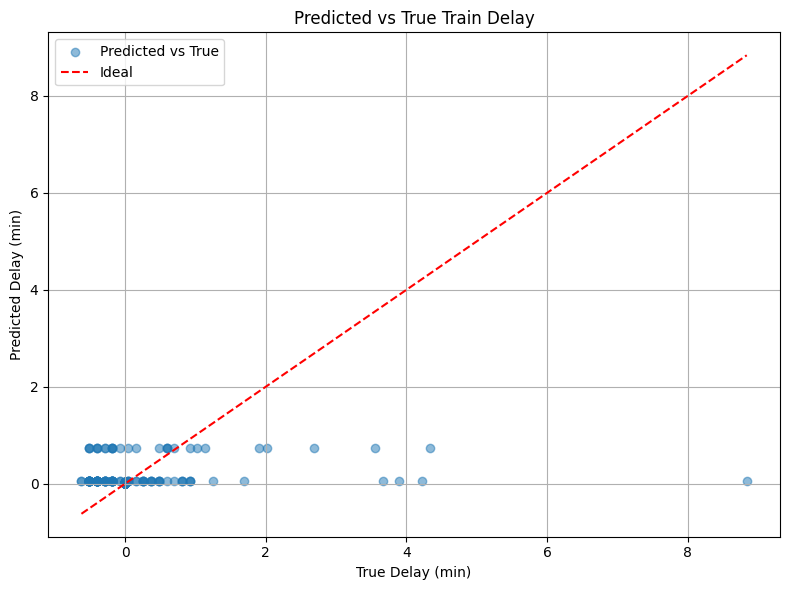

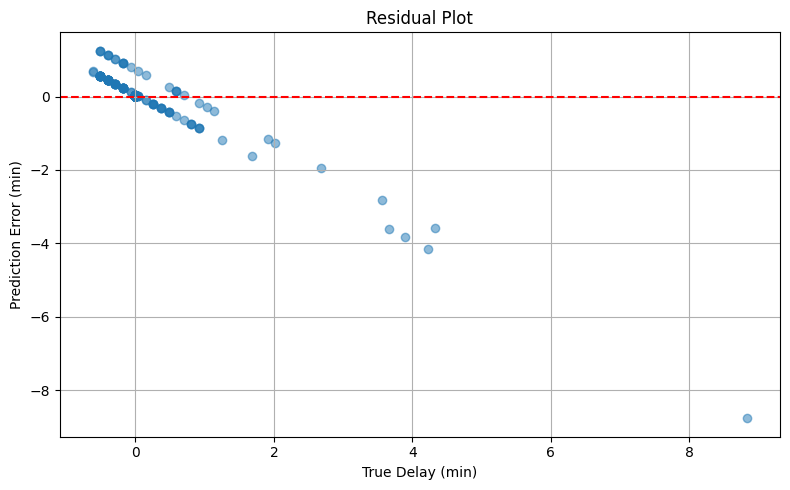

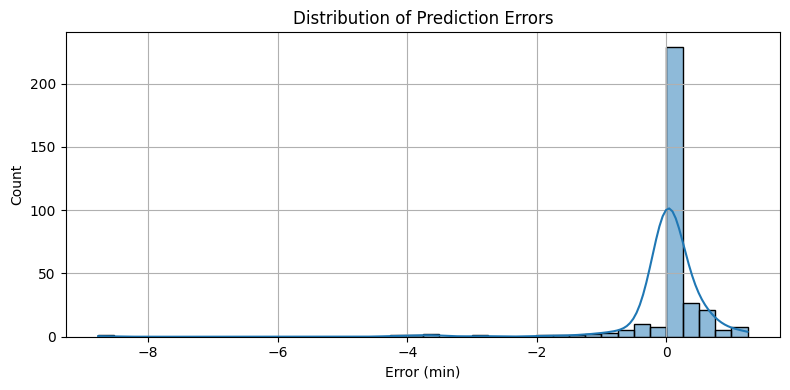

In [61]:
preds = torch.tensor(model.test_predictions)
targets = torch.tensor(model.test_targets)

plt.figure(figsize=(8, 6))
plt.scatter(targets, preds, alpha=0.5, label="Predicted vs True")
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', label="Ideal")
plt.xlabel("True Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Predicted vs True Train Delay")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

errors = preds - targets

plt.figure(figsize=(8, 5))
plt.scatter(targets, errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("True Delay (min)")
plt.ylabel("Prediction Error (min)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(errors.numpy(), bins=40, kde=True)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (min)")
plt.grid(True)
plt.tight_layout()
plt.show()